In [2]:
import numpy as np
np.set_printoptions(threshold = np.inf)
import math
%matplotlib inline
import matplotlib.pyplot as plt
import os.path
from abc import ABCMeta, abstractmethod

In [3]:
eVtofsinv = 0.2418
fsinvtoeV = 1 / eVtofsinv
pi = np.pi
tpi = 2 * pi
k = 8.61737 * 10**(-5)## eV / K unit

size = 1024
padded_size = 1024
t1_start = 0
t1_step = 1.25
t1_end = size * t1_step
t3_start = 0
t3_step = 1.25
t3_end = size * t3_step

t1_vec = np.arange(t1_start,t1_end,t1_step)
t3_vec = np.arange(t3_start,t3_end,t3_step)
t1_mat = t1_vec * np.ones((size,size))
t3_mat = t1_mat.T
t3_m_t1 = t3_mat - t1_mat
t3_p_t1 = t3_mat + t1_mat

E01 = 2.348
E12 = 2.362
Ev = 0.185
Erf = 2.214
T2_01 = 20
T2_12 = 20
Delta = 0
amp12 = 0.95

max value : 126.56367316480957
min value : -160.84477809008382


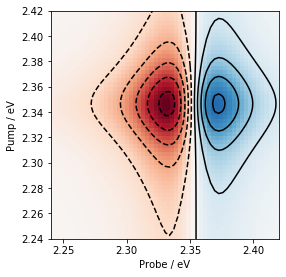

In [4]:
R1_time = np.zeros((padded_size,padded_size), dtype = np.complex)
R1_time[:size,:size] = -1 * np.exp(-1j*tpi*(E01-Erf)*eVtofsinv*t3_m_t1) * np.exp(-t3_p_t1/T2_01) * np.exp(-(Delta*eVtofsinv*t3_m_t1)**2/2)
# R1_freq = np.fft.fft2(R1_time)

R3_time = np.zeros((padded_size,padded_size), dtype=np.complex)
R3_time[:size,:size] = amp12 * np.exp(1j*tpi*(E01-Erf)*eVtofsinv*t1_mat) * np.exp(-1j*tpi*(E12-Erf)*eVtofsinv*t3_mat) \
                        * np.exp(-t1_mat/T2_01) * np.exp(-t3_mat/T2_12) * np.exp(-(Delta*eVtofsinv*t3_m_t1)**2/2)
# R3_freq = np.fft.fft2(R3_time)

R4_time = np.zeros((padded_size,padded_size), dtype=np.complex)
R4_time[:size,:size] = -1 * np.exp(-1j*tpi*(E01-Erf)*eVtofsinv*t3_p_t1) * np.exp(-t3_p_t1/T2_01) * np.exp(-(Delta*eVtofsinv*t3_p_t1)**2/2)
# R4_freq = np.fft.fft2(R4_time)

R6_time = np.zeros((padded_size,padded_size), dtype=np.complex)
R6_time[:size,:size] = amp12 * np.exp(-1j*tpi*(E01-Erf)*eVtofsinv*t1_mat) * np.exp(-1j*tpi*(E12-Erf)*eVtofsinv*t3_mat) \
                        * np.exp(-t1_mat/T2_01) * np.exp(-t3_mat/T2_12) * np.exp(-(Delta*eVtofsinv*t3_p_t1)**2/2)
# R6_freq = np.fft.fft2(R6_time)

R_time = np.zeros((padded_size,padded_size), dtype=np.complex)
R_time = R1_time + R3_time + R4_time + R6_time
R_freq = np.fft.fft2(R_time)

rephasing = R_freq[int(padded_size/2):padded_size, 0:int(padded_size/2)]
rephasing = np.flip(rephasing, axis=1)
non_rephasing = R_freq[int(padded_size/2):padded_size, int(padded_size/2):padded_size]
absorptive = rephasing + non_rephasing

max_value = np.amax(np.real(absorptive))
min_value = np.amin(np.real(absorptive))
print(f"max value : {max_value}")
print(f"min value : {min_value}")
max_abs_value = max(np.abs(max_value), np.abs(min_value))

omega1_vec = np.linspace(1/(2*t1_step)*fsinvtoeV, 0, int(padded_size/2), endpoint=True) + Erf
omega3_vec = np.linspace(1/(2*t3_step)*fsinvtoeV, 0, int(padded_size/2), endpoint=True) + Erf
omega1_mesh, omega3_mesh = np.meshgrid(omega1_vec, omega3_vec)

fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(1, 2, 1)

ax1.contour(omega3_mesh, omega1_mesh, np.real(absorptive), 10, vmax=max_abs_value, vmin=-max_abs_value, colors=['black'])
ax1.pcolormesh(omega3_mesh, omega1_mesh, np.real(absorptive), cmap='RdBu', vmax=max_abs_value, vmin=-max_abs_value)
ax1.axis([2.24, 2.42, 2.24, 2.42])
ax1.set_aspect('equal')
ax1.set_xlabel("Probe / eV")
ax1.set_ylabel("Pump / eV")

plt.show()

In [5]:
class LineShape(metaclass = ABCMeta):
    @abstractmethod
    def g(self, t):
        pass
        
class KuboLineShape(LineShape):
    
    def __init__(self, lmd, T, Lmd, lmdih, deltah, sl2, ll2, sl3, ll3):
        self.delta1 = delta1 ##eV unit
        self.T = T ## K unit
        self.Lmd = Lmd ## eV unit
        self.deltaih = deltaih
        self.deltah =deltah
        self.delta2 = delta2
        self.ll2 = ll2
        self.delta3 = delta3
        self.ll3 = ll3
    def g(self, t):
        return 2*pi*self.delta1*self.delta1/(eVtofsinv**2*self.Lmd**2)*(np.exp(-self.Lmd*eVtofsinv*t)+self.Lmd*eVtofsinv*t-1)\
    +2*pi*self.delta2*self.delta2/(eVtofsinv**2*self.ll2**2)*(np.exp(-self.ll2*eVtofsinv*t)+self.ll2*eVtofsinv*t-1)\
    +2*pi*self.delta3*self.delta3/(eVtofsinv**2*self.ll3**2)*(np.exp(-self.ll3*eVtofsinv*t)+self.ll3*eVtofsinv*t-1)\
    +pi*self.deltaih*self.deltaih*t*t+2*pi*self.deltah*t
class BlochLineShape(LineShape):
    
    def __init__(self, T2, Delta):
        self.T2 = T2
        self.Delta = Delta
        
    def g(self, t):
        return t/self.T2 + (self.Delta*eVtofsinv*t)**2/2

In [6]:
class ThirdOrderResponse(object):
    def __init__(self, lineshape):
        self.lineshape = lineshape
    
    def rephasing(self, t1, t2, t3, omega_array, mu_array):
        oscillator_strength = np.prod(mu_array)
        
        oscillating_part = np.exp(1j*omega_array[0]*t1 - 1j*omega_array[1]*t3)
        
        g_t1 = self.lineshape.g(t1)
        g_t2 = self.lineshape.g(t2)
        g_t3 = self.lineshape.g(t3)
        g_t1t2 = self.lineshape.g(t1+t2)
        g_t2t3 = self.lineshape.g(t2+t3)
        g_t1t2t3 = self.lineshape.g(t1+t2+t3)
        lineshape_part = np.exp(-g_t1 + g_t2 - g_t3 - g_t1t2 - g_t2t3 + g_t1t2t3)
        
        return oscillator_strength * oscillating_part * lineshape_part
    
    def nonrephasing(self, t1, t2, t3, omega_array, mu_array):
        oscillator_strength = np.prod(mu_array)
        
        oscillating_part = np.exp(-1j*omega_array[0]*t1 - 1j*omega_array[1]*t3)
        
        g_t1 = self.lineshape.g(t1)
        g_t2 = self.lineshape.g(t2)
        g_t3 = self.lineshape.g(t3)
        g_t1t2 = self.lineshape.g(t1+t2)
        g_t2t3 = self.lineshape.g(t2+t3)
        g_t1t2t3 = self.lineshape.g(t1+t2+t3)
        lineshape_part = np.exp(-g_t1 - g_t2 - g_t3 + g_t1t2 + g_t2t3 - g_t1t2t3)
        
        return oscillator_strength * oscillating_part * lineshape_part

max value : 1178.1686890262952
min value : -1139.4839881451346
1178.1686890262952


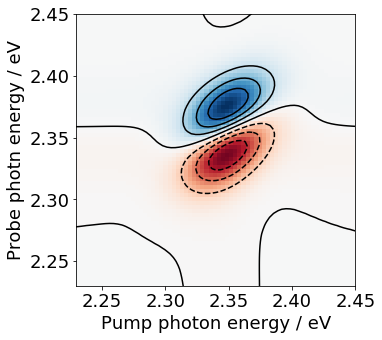

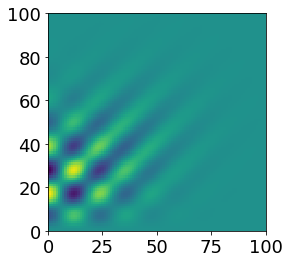

In [27]:
size = 1024
padded_size = 1024
t1_start = 0
t1_step = 1.25
t1_end = size * t1_step
t3_start = 0
t3_step = 1.25
t3_end = size * t3_step

t1_vec = np.arange(t1_start,t1_end,t1_step)
t3_vec = np.arange(t3_start,t3_end,t3_step)
t1_mat = t1_vec * np.ones((size,size))
t3_mat = t1_mat.T
t3_m_t1 = t3_mat - t1_mat
t3_p_t1 = t3_mat + t1_mat

E01 = 2.35
E12 = 2.37
Ev = 0.185
Erf = 2.214

delta1 = 0.0063
T = 96
Lmd = 0.01034
deltaih = 0.0088
deltah = 0
delta2 = 0.0087
ll2 = 0.04136
delta3 = 0
ll3 = 0.2
t2 = 1000
mu00 = 1
mu01 = 1
mu11 = 1
mu12 = 1

lineshape = KuboLineShape(delta1, T, Lmd, deltaih, deltah, delta2, ll2, delta3, ll3)
R = ThirdOrderResponse(lineshape)

R_time = np.zeros((padded_size,padded_size), dtype=np.complex)
R_list = []

# r_gsb_00 & nr_gsb_00
omega_array = np.array((tpi*(E01-Erf)*eVtofsinv, tpi*(E01-Erf)*eVtofsinv))
mu_array = np.array((mu00,mu00,mu00,mu00))
r_gsb_00 = R.rephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
nr_gsb_00 = R.nonrephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
R_list.append(r_gsb_00)
R_list.append(nr_gsb_00)

# # r_gsb_01 & nr_gsb_01
# omega_array = np.array((tpi*(E01-Erf)*eVtofsinv, tpi*(E01+Ev-Erf)*eVtofsinv))
# mu_array = np.array((mu00,mu00,mu01,mu01))
# r_gsb_01 = R.rephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
# nr_gsb_01 = R.nonrephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
# R_list.append(r_gsb_01)
# R_list.append(nr_gsb_01)

# # r_gsb_10 & nr_gsb_10
# omega_array = np.array((tpi*(E01+Ev-Erf)*eVtofsinv, tpi*(E01-Erf)*eVtofsinv))
# mu_array = np.array((mu01,mu01,mu00,mu00))
# r_gsb_10 = R.rephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
# nr_gsb_10 = R.nonrephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
# R_list.append(r_gsb_10)
# R_list.append(nr_gsb_10)

# # r_gsb_11 & nr_gsb_11
# omega_array = np.array((tpi*(E01+Ev-Erf)*eVtofsinv, tpi*(E01+Ev-Erf)*eVtofsinv))
# mu_array = np.array((mu01,mu01,mu01,mu01))
# r_gsb_11 = R.rephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
# nr_gsb_11 = R.nonrephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
# R_list.append(r_gsb_11)
# R_list.append(nr_gsb_11)

# r_se_00 & nr_se_00
#omega_array = np.array((tpi*(E01-Erf)*eVtofsinv, tpi*(E01-Erf)*eVtofsinv))
#mu_array = np.array((mu00,mu00,mu00,mu00))
#r_se_00 = R.rephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
#nr_se_00 = R.nonrephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
#R_list.append(r_se_00)
#R_list.append(nr_se_00)

# # r_se_01 & nr_se_01
# omega_array = np.array((tpi*(E01-Erf)*eVtofsinv, tpi*(E01-Ev-Erf)*eVtofsinv))
# mu_array = np.array((mu00,mu00,mu01,mu01))
# r_se_01 = R.rephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
# nr_se_01 = R.nonrephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
# R_list.append(r_se_01)
# R_list.append(nr_se_01)

# # r_se_10 & nr_se_10
# omega_array = np.array((tpi*(E01+Ev-Erf)*eVtofsinv, tpi*(E01-Erf)*eVtofsinv))
# mu_array = np.array((mu01,mu01,mu11,mu11))
# r_se_10 = R.rephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
# nr_se_10 = R.nonrephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
# R_list.append(r_se_10)
# R_list.append(nr_se_10)

# # r_se_11 & nr_se_11
# omega_array = np.array((tpi*(E01+Ev-Erf)*eVtofsinv, tpi*(E01+Ev-Erf)*eVtofsinv))
# mu_array = np.array((mu01,mu01,mu01,mu01))
# r_se_11 = R.rephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
# nr_se_11 = R.nonrephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
# R_list.append(r_se_11)
# R_list.append(nr_se_11)

#r_esa_00 & nr_esa_00
omega_array = np.array((tpi*(E01-Erf)*eVtofsinv, tpi*(E12-Erf)*eVtofsinv))
mu_array = np.array((mu00,mu00,mu12,mu12))
r_esa_00 = -R.rephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
nr_esa_00 = -R.nonrephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
R_list.append(r_esa_00)
R_list.append(nr_esa_00)

# # r_esa_01 & nr_esa_01
# omega_array = np.array((tpi*(E01-Erf)*eVtofsinv, tpi*(E12+Ev-Erf)*eVtofsinv))
# mu_array = np.array((mu00,mu00,mu12,mu12))
# r_esa_01 = -R.rephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
# nr_esa_01 = -R.nonrephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
# R_list.append(r_esa_01)
# R_list.append(nr_esa_01)

# # r_esa_10 & nr_esa_10
# omega_array = np.array((tpi*(E01+Ev-Erf)*eVtofsinv, tpi*(E12-Ev-Erf)*eVtofsinv))
# mu_array = np.array((mu01,mu01,mu12,mu12))
# r_esa_10 = -R.rephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
# nr_esa_10 = -R.nonrephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
# R_list.append(r_esa_10)
# R_list.append(nr_esa_10)

# # r_esa_11 & nr_esa_11
# omega_array = np.array((tpi*(E01+Ev-Erf)*eVtofsinv, tpi*(E12-Erf)*eVtofsinv))
# mu_array = np.array((mu01,mu01,mu12,mu12))
# r_esa_11 = -R.rephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
# nr_esa_11 = -R.nonrephasing(t1_mat, t2, t3_mat, omega_array, mu_array)
# R_list.append(r_esa_11)
# R_list.append(nr_esa_11)

R_time = -sum(R_list)
R_freq = np.fft.fft2(R_time)

rephasing = R_freq[int(padded_size/2):padded_size, 0:int(padded_size/2)]
rephasing = np.flip(rephasing, axis=1)
non_rephasing = R_freq[int(padded_size/2):padded_size, int(padded_size/2):padded_size]
absorptive = rephasing + non_rephasing

max_value = np.amax(np.real(absorptive))
min_value = np.amin(np.real(absorptive))
print(f"max value : {max_value}")
print(f"min value : {min_value}")
max_abs_value = max(np.abs(max_value), np.abs(min_value))
print(max_abs_value)

fig = plt.figure(figsize=(5,5))
plt.rcParams["font.size"] = 18
ax = plt.axes()
ax.contour(omega1_mesh, omega3_mesh, np.real(absorptive), 7, vmax=max_abs_value, vmin=-max_abs_value, colors=['black'])
ax.pcolormesh(omega1_mesh, omega3_mesh, np.real(absorptive), cmap='RdBu', vmax=max_abs_value, vmin=-max_abs_value)
ax.axis([2.23, 2.45, 2.23, 2.45])
ax.set_xlabel("Pump photon energy / eV")
ax.set_ylabel("Probe photn energy / eV")
plt.show()

plt.imshow(np.real(R_time))
plt.axis([0,100,0,100])
plt.show()